# Initialization

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import copy
import time

import preprocess
import pytorch_utils


dataset = preprocess.DatasetPreprocess("FinalData_Reshaped.csv", sequence_length=0, is_dataset_reshaped = True)

print("\nInitializing PyTorch...")
utils = pytorch_utils.Utils(dataset, use_cuda = False)

input_size = dataset.X_train_c.shape[1]
output_size = dataset.Y_train.shape[1]

categorical_variables: ['day_in_a_week', 'month', 'hour', '中山_status', '北投_status', '北門_status', '古亭_status', '士林_status', '大橋頭_status', '松山_status']
metro_flow index:  [0, 1, 2, 3, 4, 5, 6] 
categorical indices:  [14, 15, 16, 36, 37, 38, 39, 40, 41, 42] 
numerical indices:  [7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147]


7 unique day_in_a_week:	 [2.0, 3.0, 4.0, 5.0, 6.0, 0.0, 1.0]
12 unique month:	 [6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0]
24 unique

C:\Users\vital\anaconda3\envs\FinTech\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\vital\anaconda3\envs\FinTech\lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


# LinearRegression Implementation

In [2]:
class Linear_Regression(nn.Module):
    def __init__(self, params):
        super(Linear_Regression, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

    def get_input_weights(self):
        return self.fc.weight

gamma per epoch: 3.7144712429378357
residual: 2.9103830456733704e-10

Initial: Train loss: 0.7914997

Step:1 	Train loss: 0.7730011 	LR: 1e-06
Step:2 	Train loss: 0.7291357 	LR: 3.7144712429378356e-06
Step:3 	Train loss: 0.6107185 	LR: 1.379729661461215e-05
Step:4 	Train loss: 0.4105267 	LR: 5.124966150526038e-05
Step:5 	Train loss: 0.2260718 	LR: 0.0001903653938715879
Step:6 	Train loss: 0.1322607 	LR: 0.0007071067811865477
Step:7 	Train loss: 0.0987442 	LR: 0.002626527804403768
Step:8 	Train loss: 0.2505654 	LR: 0.00975616199823445
Step:9 	Train loss: 2.5169373 	LR: 0.03623898318388479
Step:10 	Train loss: 40.9446740 	LR: 0.13460866090984788

Time to train: 52.240s


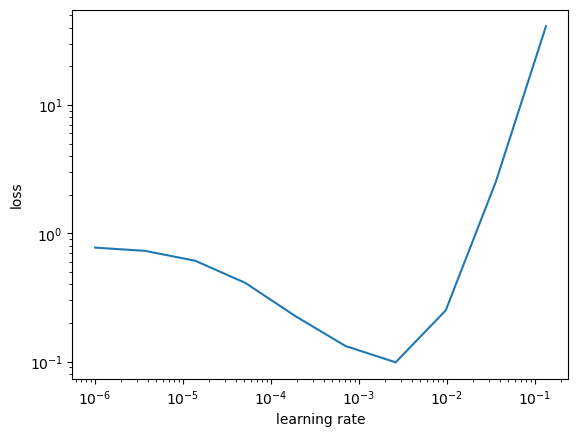

Best learning rate: 0.002626527804403768
best_lr: 0.002626527804403768
batch size of 8192 is larger than the dataset size!
max_batch_size: 4096


In [3]:
# Find the best initial learning rate
params = {'batch_size': 4, 'epochs' : 10, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
min_lr = 1e-6
max_lr = 5e-1

model, train_losses, learning_rates, best_lr_LR = utils.Learning_Rate_Range_Test(Linear_Regression, min_lr, max_lr, params)
print("best_lr:", best_lr_LR)

# Find the maximum batch size
max_batch_size_LR = utils.get_max_batch_size(model)

# Training

In [4]:
# Parameters for grid search
epochs = [20, 50, 100]
batch_size = [4]
lrs = [best_lr_LR]
weight_decay = [0]
batch_growths = [True, False]
loss = ["MSE"]
l1_reg = [0]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, l1_reg]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "l1_reg"]
params = utils.create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
best_val_params_LR, grid_train_losses_LR, grid_val_losses_LR = utils.grid_search(Linear_Regression, params, max_batch_size_LR)

print("Final training for the min val loss:")
best_model_LR, best_val_loss_LR, final_model_LR, train_losses_LR, val_losses_LR = utils.train_model(Linear_Regression, best_val_params_LR, max_batch_size_LR, print_mode=True)

All grid searched values:
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
	 {'epochs': 50, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
	 {'epochs': 50, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
	 {'epochs': 100, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
	 {'epochs': 100, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}

Grid search step 1/6 	| params: {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
Epoch:20 	Train loss:

# Evaluation

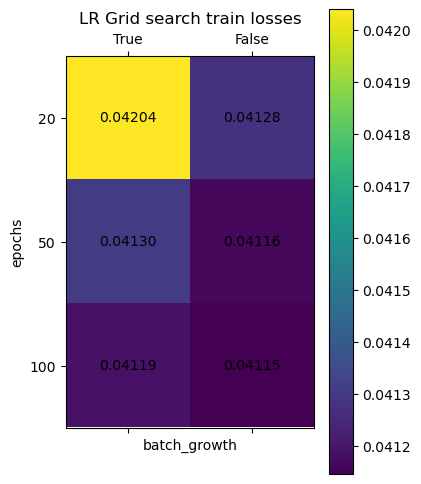

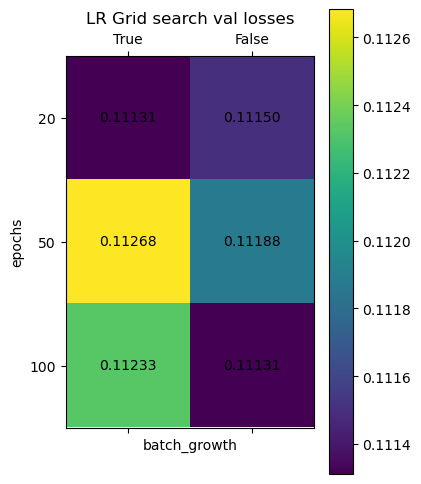

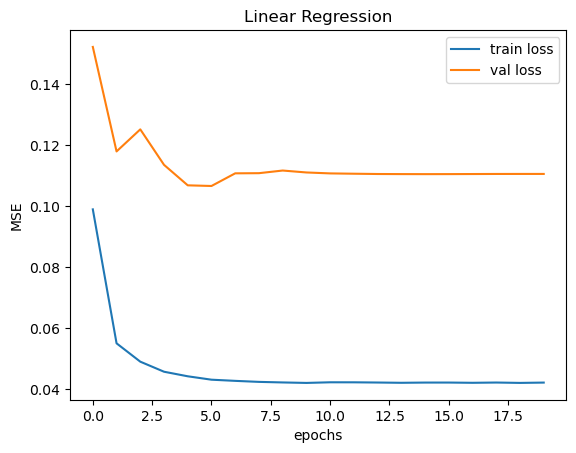

best val params:  {'epochs': 20, 'batch_size': 4, 'lr': 0.002626527804403768, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'l1_reg': 0}
Train metrics:
	MSE: 0.04284427799946385
	Original scale MSE: 122912.6777552714

	RMSE: 0.20698859388735374
	Original scale RMSE: 350.5890439749528

	MAE: 0.1387563913708549
	Original scale MAE: 228.3225550421431

Validation metrics:
	MSE: 0.1066494065519857
	Original scale MSE: 275639.42231516493

	RMSE: 0.32657220725589264
	Original scale RMSE: 525.013735358576

	MAE: 0.19705318073484437
	Original scale MAE: 317.62456407950486

Test metrics:
	MSE: 0.09634530105494692
	Original scale MSE: 232864.3746971352

	RMSE: 0.31039539470640815
	Original scale RMSE: 482.56022908766033

	MAE: 0.2121728008882679
	Original scale MAE: 332.95509801325244


In [6]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_LR)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_LR[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_LR[i]

utils.plot_grid(grid_values=train_grid, title="LR Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
utils.plot_grid(grid_values=val_grid  , title="LR Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
utils.plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best val params: ", best_val_params_LR)
utils.evaluate_model(best_model_LR, max_batch_size_LR)